# Qiskit Workshop: Sample-based Quantum Diagonalization (SQD)

#### Requirements:

- `qiskit_addon_sqd`
- `pyscf`

#### Premise

Solve the following Fermionic Hamiltonian for a given molecule and find the ground state energy:

\begin{split}\hat{H} = \sum_{ \substack{pr\\\sigma} } h_{pr} \, \hat{a}^\dagger_{p\sigma} \hat{a}_{r\sigma}
+
\sum_{ \substack{prqs\\\sigma\tau} }
\frac{(pr|qs)}{2} \,
\hat{a}^\dagger_{p\sigma}
\hat{a}^\dagger_{q\tau}
\hat{a}_{s\tau}
\hat{a}_{r\sigma}\end{split}


#### Method: SQD

<img src='https://qiskit.github.io/qiskit-addon-sqd/_images/sqd_diagram.png' width=75%>




In [23]:
import warnings

warnings.filterwarnings("ignore")

import utils

import numpy as np

## Step -1: Initiate Qiskit Runtime

In [24]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name='pinq2')
backend = service.backend('ibm_quebec')

#from qiskit_ibm_runtime.fake_provider import FakeQuebec

#backend = FakeQuebec()

## Step 0: Define the molecule

Molecule of interest: nitrogen ($\text{N}_2$)

Use PySCF library to classically compute some needed quantities.

In [25]:
import pyscf
import pyscf.cc
import pyscf.mcscf

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

converged SCF energy = -108.835236570775


In [4]:
active_space

range(2, 18)

In [5]:
# Compute exact energy
exact_energy = cas.run().e_tot

CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


Get initial estimate of t1 and t2 amplitudes from classical coupled cluster methods (CCSD)

In [26]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929733  E_corr = -0.2045891221988306


## Step 1: Create a quantum circuit

Use the Local Unitary Cluster Jastrow (LUCJ) ansatz from the `ffsim` library.

<img src='https://pubs.rsc.org/image/article/2023/sc/d3sc02516k/d3sc02516k-f2.gif'>

In [27]:
import ffsim
from qiskit import QuantumCircuit, QuantumRegister

n_reps = 2
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

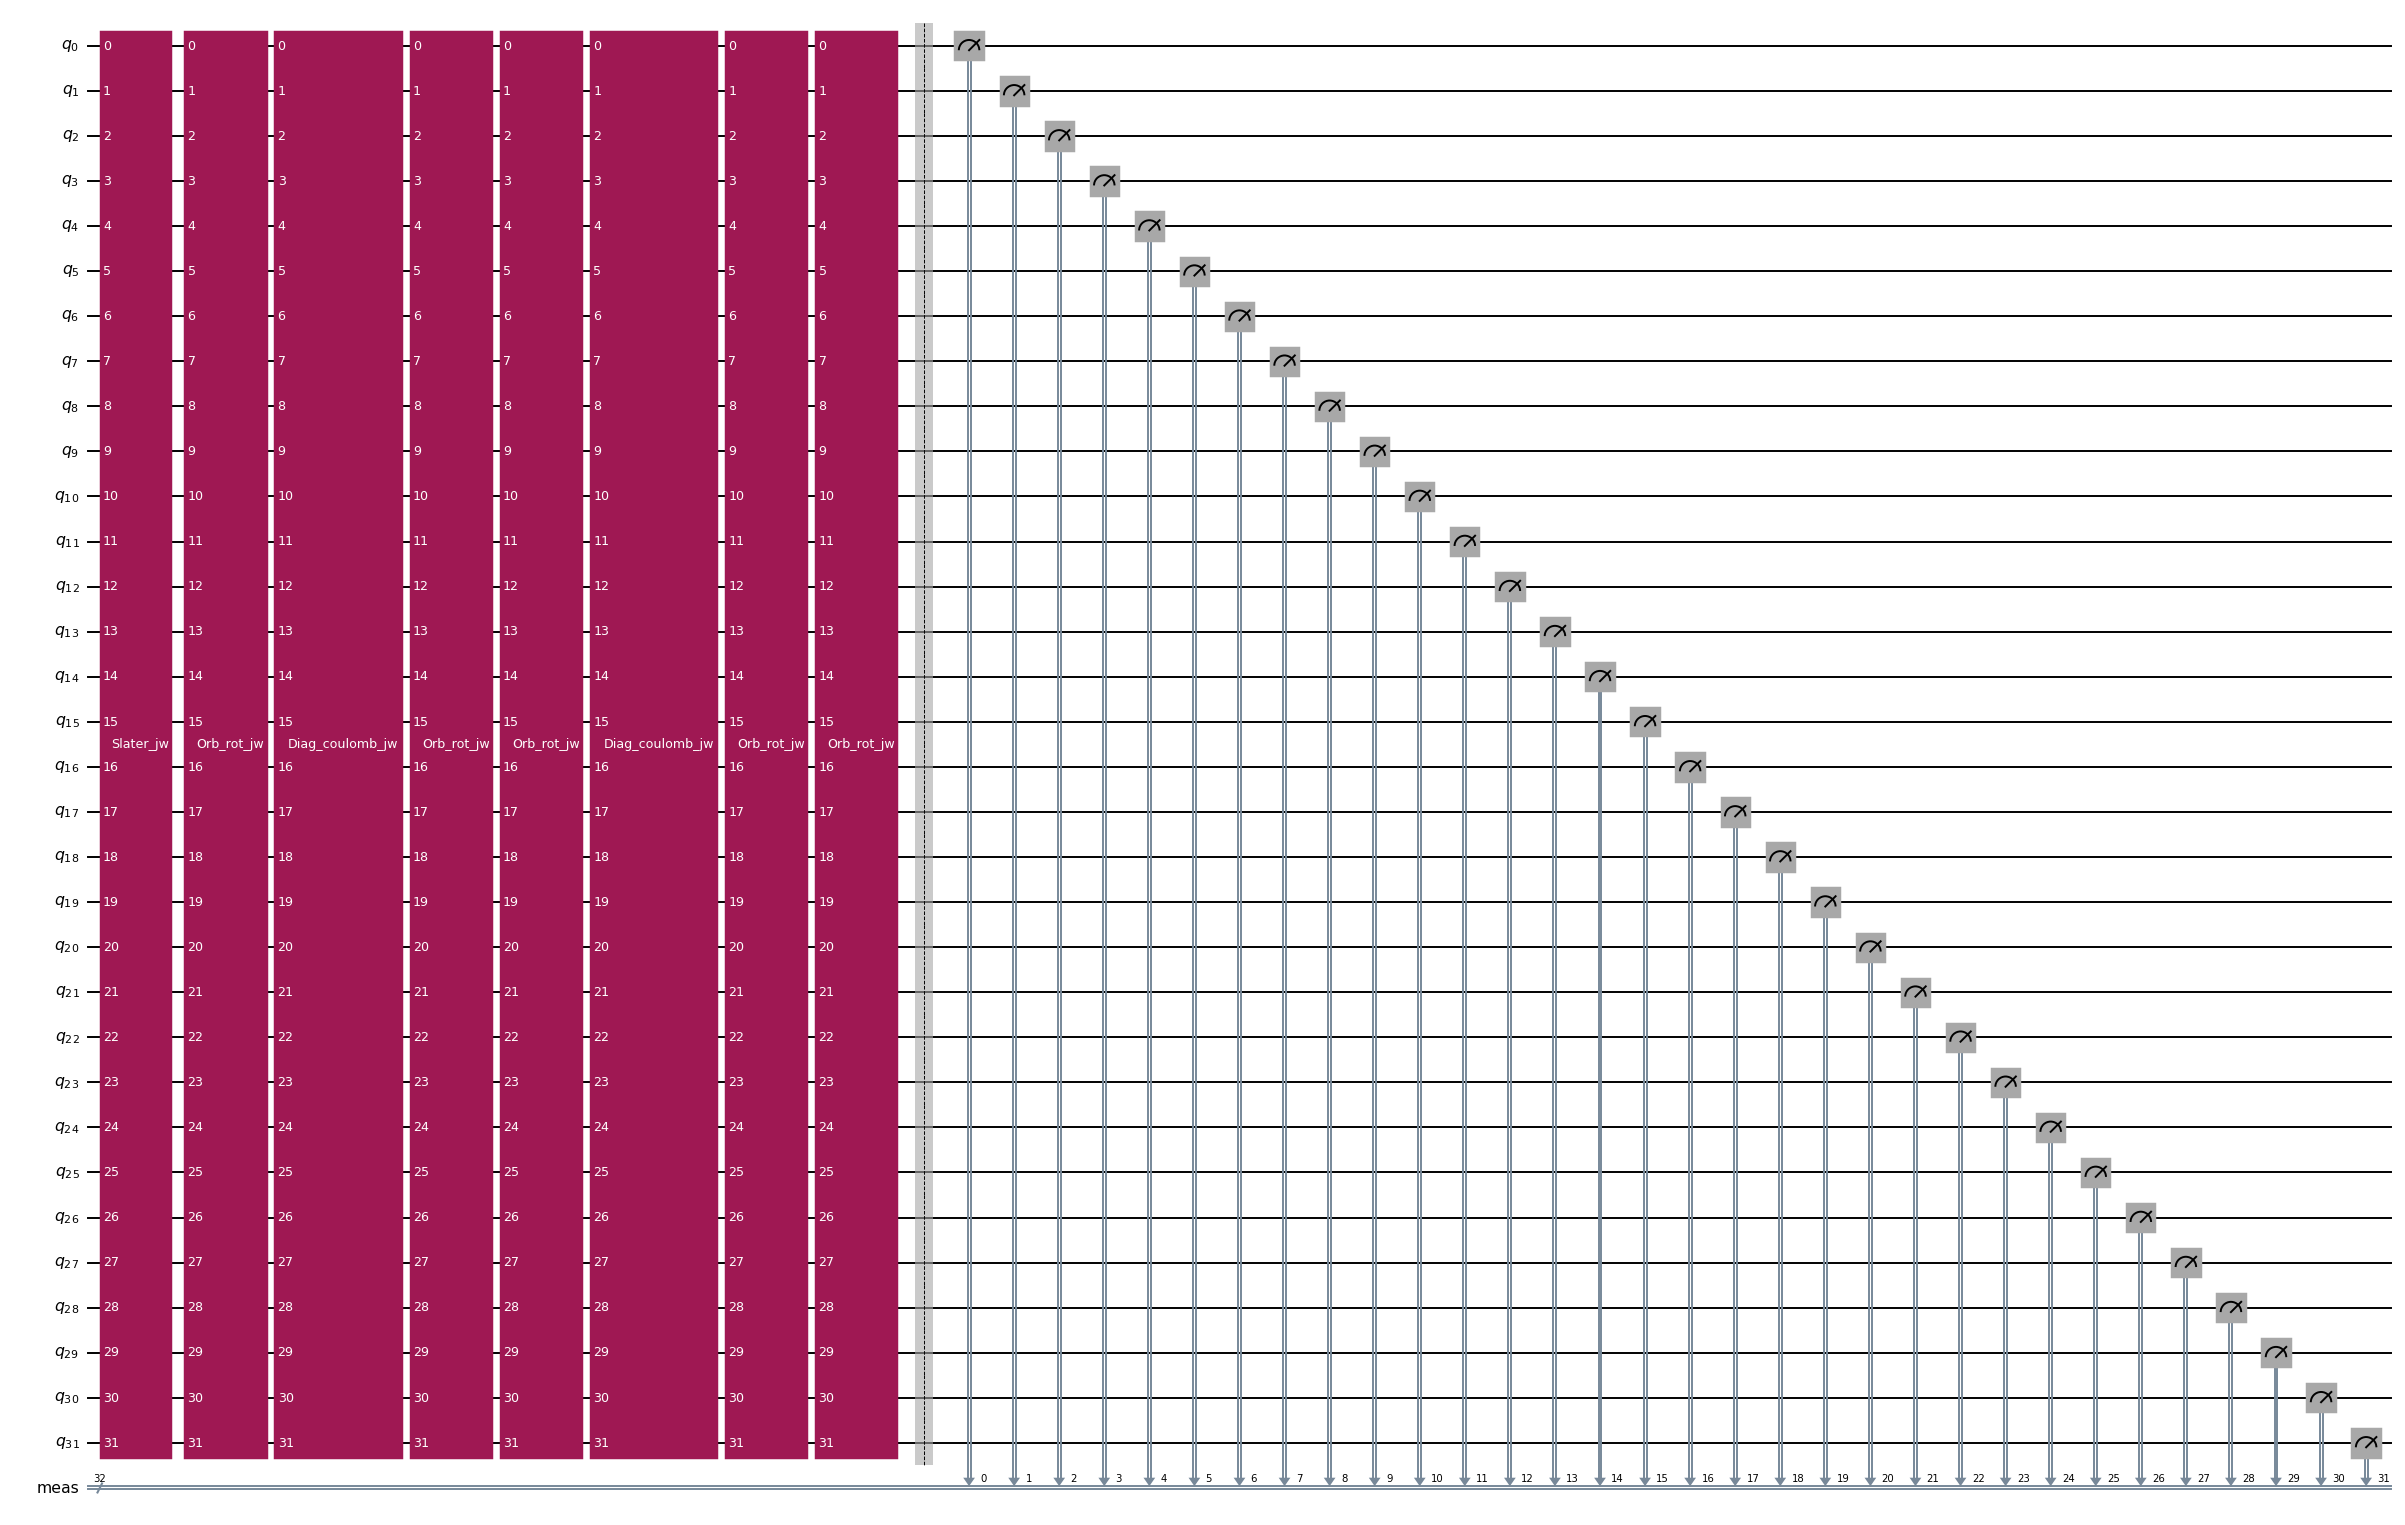

In [28]:
circuit.decompose().draw(scale=0.7, fold=False)

## Step 2: Transpile the circuit

Map circuit to layout of QPU to get best results.

<img src=https://qiskit.github.io/qiskit-addon-sqd/_images/lucj_ansatz_zig_zag_pattern.jpg>

In [34]:
from qiskit.transpiler import generate_preset_pass_manager

#initial_layout = None

spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, 
    backend=backend, 
    initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes):  {isa_circuit.count_ops()}")
print(f'2-qubit depth (w/o pre-init pases): {utils.get_2q_gate_depth(isa_circuit)}')

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes):   {isa_circuit.count_ops()}")
print(f'2-qubit depth (w/ pre-init pases):  {utils.get_2q_gate_depth(isa_circuit)}')

Gate counts (w/o pre-init passes):  OrderedDict({'rz': 7368, 'sx': 6030, 'ecr': 2316, 'x': 422, 'measure': 32, 'barrier': 1})
2-qubit depth (w/o pre-init pases): 186
Gate counts (w/ pre-init passes):   OrderedDict({'rz': 4033, 'sx': 3108, 'ecr': 1262, 'x': 226, 'measure': 32, 'barrier': 1})
2-qubit depth (w/ pre-init pases):  122


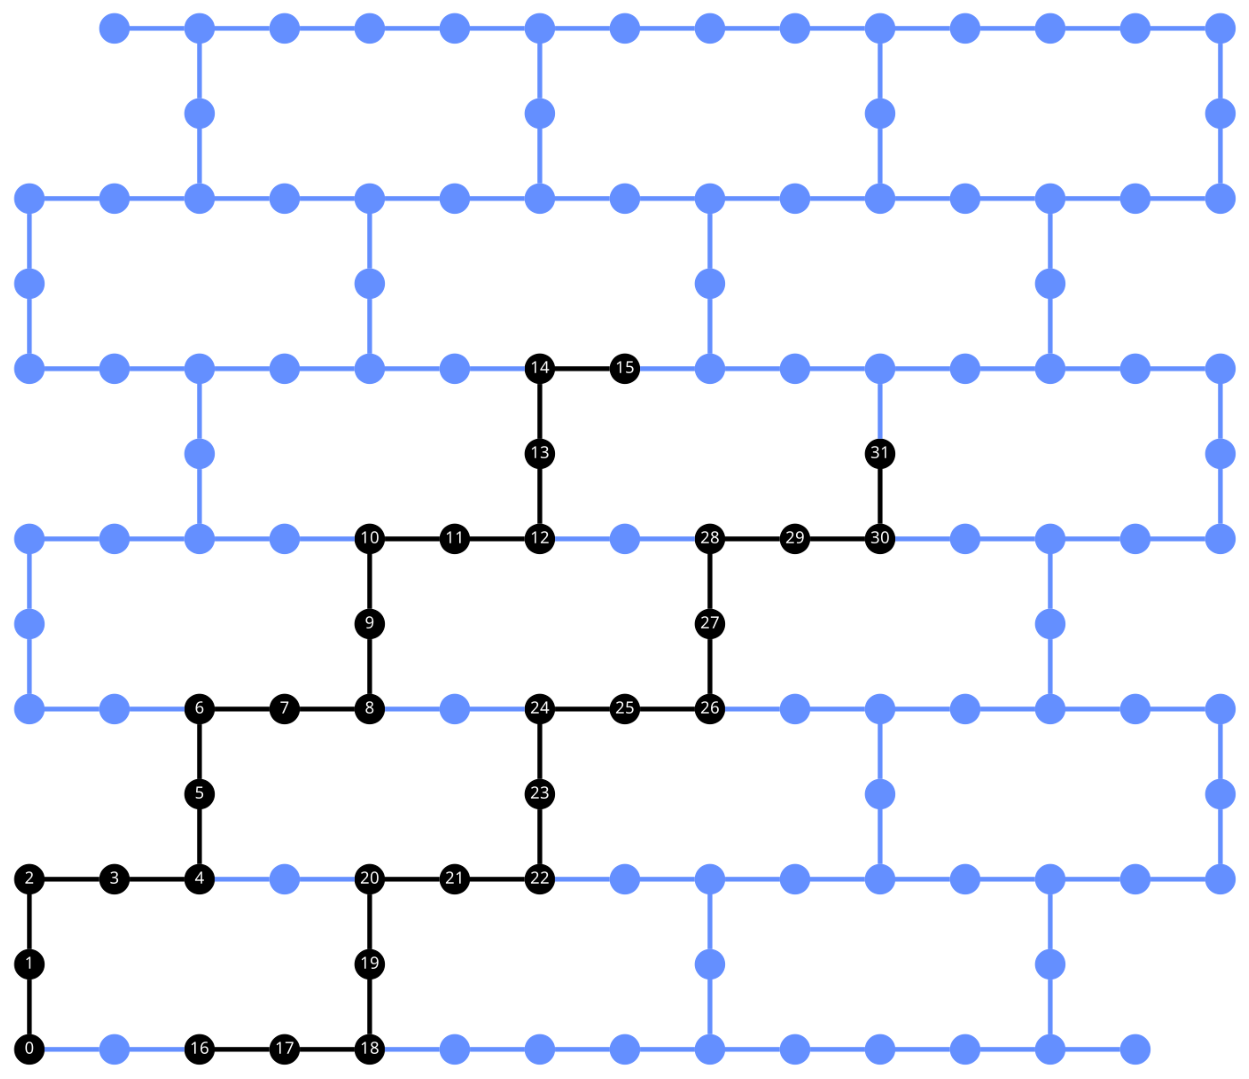

In [30]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(isa_circuit, backend)

## Step 3: Run circuit

In [18]:
import numpy as np
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=10000)
print(job.job_id())

cxjxkzfvw7kg008sfvc0


In [20]:
job.status()

'DONE'

In [10]:
job = service.job('cxjxkzfvw7kg008sfvc0')

In [11]:
# Get the bitstrings sampled
primitive_result = job.result()
pub_result = primitive_result[0]
counts = pub_result.data.meas.get_counts()
counts

{'00000001111001010100001111110101': 1,
 '00101101011001011100111010010101': 1,
 '01100110110100001100111011000100': 1,
 '10101101110000111100101010110100': 1,
 '10000011000110110000100111101111': 1,
 '01111010001000101111001011100100': 1,
 '10010001010011011001010100110100': 1,
 '10001010110111001110111101101000': 1,
 '00101111010110100110011010000110': 1,
 '01011110111110101010100100101101': 1,
 '11010000011010111110100001011111': 1,
 '00000001101010001001000110001100': 1,
 '11101110101010110101110000000111': 1,
 '00101010000011000111110101010100': 1,
 '00111100100011101000010101111100': 1,
 '00010101001000001110011011001100': 1,
 '11110001000101010111110000011000': 1,
 '01101101100110100110111001100101': 1,
 '11011101110110111011001010100011': 1,
 '11010010110110111101101000000011': 1,
 '00010110111101110110110100011011': 1,
 '01001010011111110111110011010010': 1,
 '00000000110010000110000010011111': 1,
 '10100001110101000011010011111011': 1,
 '00101010101011111100011001100011': 1,


In [16]:
# Save the results to a file

import pickle

with open('n2_bitstring_counts.cxjxkzfvw7kg008sfvc0.pkl', 'wb') as file:
    pickle.dump(counts, file)

In [17]:
# Load the results that were saved to the file

with open('n2_bitstring_counts.cxjxkzfvw7kg008sfvc0.pkl', 'rb') as file:
    counts = pickle.load(file)

## Step 4: Postprocess results

Use the SQD classical postprocessing methods to compute final ground state energy. The process includes:

- Configuration recovery
- Project/Diagonalize batches of samples in smaller subspaces
- Iterate and converge to lowest energy

In [18]:
from qiskit_addon_sqd.counts import counts_to_arrays

# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)

In [11]:
rng_seed = 24
rng = np.random.default_rng(rng_seed)

In [12]:
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.fermion import (
    flip_orbital_occupancies,
    solve_fermion,
)
from qiskit_addon_sqd.subsampling import postselect_and_subsample

# SQD options
iterations = 5

# Eigenstate solver options
n_batches = 10
samples_per_batch = 300
max_davidson_cycles = 200

# Self-consistent configuration recovery loop
e_hist = np.zeros((iterations, n_batches))  # energy history
s_hist = np.zeros((iterations, n_batches))  # spin history
occupancy_hist = np.zeros((iterations, 2 * num_orbitals))
occupancies_bitwise = None  # orbital i corresponds to column i in bitstring matrix
for i in range(iterations):
    print(f"Starting configuration recovery iteration {i}")
    # On the first iteration, we have no orbital occupancy information from the
    # solver, so we just post-select from the full bitstring set based on hamming weight.
    if occupancies_bitwise is None:
        bs_mat_tmp = bitstring_matrix_full
        probs_arr_tmp = probs_arr_full

    # If we have average orbital occupancy information, we use it to refine the full set of noisy configurations
    else:
        bs_mat_tmp, probs_arr_tmp = recover_configurations(
            bitstring_matrix_full,
            probs_arr_full,
            occupancies_bitwise,
            num_elec_a,
            num_elec_b,
            rand_seed=rng_seed,
        )

    # Throw out configurations with incorrect particle number in either the spin-up or spin-down systems
    batches = postselect_and_subsample(
        bs_mat_tmp,
        probs_arr_tmp,
        hamming_right=num_elec_a,
        hamming_left=num_elec_b,
        samples_per_batch=samples_per_batch,
        num_batches=n_batches,
        rand_seed=rng_seed,
    )

    # Run eigenstate solvers in a loop. This loop should be parallelized for larger problems.
    e_tmp = np.zeros(n_batches)
    s_tmp = np.zeros(n_batches)
    occs_tmp = np.zeros((n_batches, 2 * num_orbitals))
    coeffs = []
    for j in range(n_batches):
        energy_sci, coeffs_sci, avg_occs, spin = solve_fermion(
            batches[j],
            hcore,
            eri,
            open_shell=open_shell,
            spin_sq=spin_sq,
            max_davidson=max_davidson_cycles,
        )
        energy_sci += nuclear_repulsion_energy
        e_tmp[j] = energy_sci
        s_tmp[j] = spin
        occs_tmp[j, :num_orbitals] = avg_occs[0]
        occs_tmp[j, num_orbitals:] = avg_occs[1]
        coeffs.append(coeffs_sci)

    # Combine batch results
    avg_occupancy = np.mean(occs_tmp, axis=0)
    # The occupancies from the solver should be flipped to match the bits in the bitstring matrix.
    occupancies_bitwise = flip_orbital_occupancies(avg_occupancy)

    # Track optimization history
    e_hist[i, :] = e_tmp
    s_hist[i, :] = s_tmp
    occupancy_hist[i, :] = avg_occupancy

Starting configuration recovery iteration 0
Starting configuration recovery iteration 1
Starting configuration recovery iteration 2
Starting configuration recovery iteration 3
Starting configuration recovery iteration 4


#### Plot the results

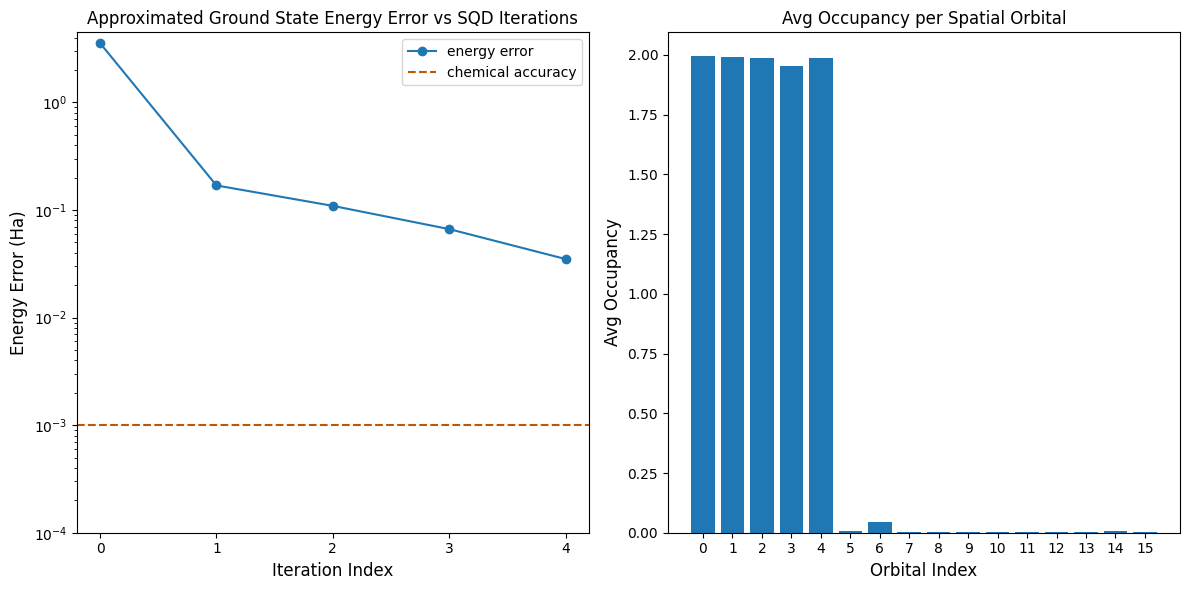

In [19]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(iterations)
e_diff = [abs(np.min(energies) - exact_energy) for energies in e_hist]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = avg_occupancy[:num_orbitals] + avg_occupancy[num_orbitals:]
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()